## Read and Process `Merged_DF`

In [1]:
import pandas as pd

# 读取CSV文件
merged_df = pd.read_csv('crawler_data/merged_results_strict.csv')

# 显示总行数
print(f"数据集总行数: {len(merged_df)}")

# 显示数据基本信息
print("\n数据集基本信息:")
print(merged_df.info())

数据集总行数: 222770

数据集基本信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222770 entries, 0 to 222769
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   arXiv Code                   222770 non-null  object
 1   Categories                   222770 non-null  object
 2   Title                        222770 non-null  object
 3   Abstract                     222770 non-null  object
 4   Submission Date              222770 non-null  int64 
 5   Primary_Subclass             222770 non-null  object
 6   DOI                          222770 non-null  object
 7   Crossref Title               222770 non-null  object
 8   Comparison                   222770 non-null  object
 9   Preprocessed Original Title  222770 non-null  object
 10  Preprocessed Crossref Title  222770 non-null  object
 11  Authors                      222747 non-null  object
 12  References_DOI               222770 non-null  o

In [2]:
# 统计References_DOI列中每个值的出现频率
# 检查References_DOI列的唯一性
doi_counts = merged_df["References_DOI"].value_counts()
print("\nReferences_DOI重复值统计:")
print(f"总共有 {len(doi_counts)} 个不同的References_DOI")
print(f"其中出现1次的有 {len(doi_counts[doi_counts==1])} 个")
print(f"出现多次的有 {len(doi_counts[doi_counts>1])} 个")

# 显示重复最多的前5个
print("\n重复最多的References_DOI:")
print(doi_counts.head())


References_DOI重复值统计:
总共有 222769 个不同的References_DOI
其中出现1次的有 222768 个
出现多次的有 1 个

重复最多的References_DOI:
References_DOI
10.1017/CBO9780511526022||10.1142/S0218271814440027||10.1142/S021988781650078X||10.1063/1.1705279||10.1142/S0219887817500372||10.1007/s00006-017-0816-9||10.1140/epjc/s10052-018-5706-3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [3]:
# 找到包含这组特定References_DOI的文章
specific_refs = "10.1017/CBO9780511526022||10.1142/S0218271814440027||10.1142/S021988781650078X||10.1063/1.1705279||10.1142/S0219887817500372||10.1007/s00006-017-0816-9||10.1140/epjc/s10052-018-5706-3"

# 显示这些文章的关键信息
articles = merged_df[merged_df["References_DOI"] == specific_refs][["Title", "DOI", "References_DOI"]]
print("\n重复出现的文章信息：")
print(articles)

merged_df = merged_df.drop(24775)


重复出现的文章信息：
                                                   Title  \
24775  Non-existence of rest-frame spin-eigenstate sp...   
37987              Covariant Inertial Forces for Spinors   

                                  DOI  \
24775  10.1140/epjc/s10052-018-5860-7   
37987  10.1140/epjc/s10052-018-6260-8   

                                          References_DOI  
24775  10.1017/CBO9780511526022||10.1142/S02182718144...  
37987  10.1017/CBO9780511526022||10.1142/S02182718144...  


In [4]:
# # 去掉重复值
# merged_df = merged_df.drop_duplicates(subset=['References_DOI'], keep='first')
# print(f"对References_DOI去重后的数据集行数: {len(merged_df)}")

# # 显示处理后的数据基本信息
# print("\n处理后的数据基本信息:")
# print(merged_df.describe())
# doi_counts = merged_df["DOI"].value_counts()
# print(doi_counts)


In [5]:
# 将Submission Date转换为日期格式
merged_df['Submission Date'] = pd.to_datetime(merged_df['Submission Date'], format='%Y%m%d')

# 添加年份列
merged_df['Year'] = merged_df['Submission Date'].dt.year

# 统计每年的论文数量
yearly_counts = merged_df['Year'].value_counts().sort_index()

# 打印统计结果
print("每年发表的论文数量：")
print(yearly_counts)

每年发表的论文数量：
Year
2018    36959
2019    37626
2020    40670
2021    40567
2022    37848
2023    29099
Name: count, dtype: int64


In [6]:
# 检查DOI是否有重复
print("DOI重复项检查:")
print(f"总行数: {len(merged_df)}")
print(f"唯一DOI数: {merged_df['DOI'].nunique()}")
print("\nDOI重复次数统计:")
print(merged_df['DOI'].value_counts()[merged_df['DOI'].value_counts() > 1])

DOI重复项检查:
总行数: 222769
唯一DOI数: 222769

DOI重复次数统计:
Series([], Name: count, dtype: int64)


## Citation Graph

In [7]:
import numpy as np
import pandas as pd

# 创建统一的DOI到索引的映射
doi_to_idx = {doi: idx for idx, doi in enumerate(merged_df['DOI'].unique())}
idx_to_doi = {idx: doi for doi, idx in doi_to_idx.items()}

# 创建Primary_Subclass到标签的映射
unique_labels = merged_df['Primary_Subclass'].unique()
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}

# 创建训练/验证/测试集的索引数组
train_idx = []
valid_idx = []
test_idx = []

# 一次性处理所有数据
for doi, year in zip(merged_df['DOI'], merged_df['Year']):
    idx = doi_to_idx[doi]
    if 2018 <= year <= 2021:
        train_idx.append(idx)
    elif year == 2022:
        valid_idx.append(idx)
    elif year == 2023:
        test_idx.append(idx)

# 转换为numpy数组并保存
np.save('raw/train_idx.npy', np.array(list(set(train_idx))))
np.save('raw/valid_idx.npy', np.array(list(set(valid_idx))))
np.save('raw/test_idx.npy', np.array(list(set(test_idx))))

# 创建完整的edges.csv
edges_list = []
for doi, refs in zip(merged_df['DOI'], merged_df['References_DOI']):
    source_idx = doi_to_idx[doi]
    ref_dois = str(refs).split('||')
    for ref_doi in ref_dois:
        ref_doi = ref_doi.strip()
        if ref_doi in doi_to_idx:  # 只对图内的引用建立边
            target_idx = doi_to_idx[ref_doi]
            # 去掉自环
            if source_idx != target_idx:
                edges_list.append([source_idx, target_idx])

# 去掉重复边
edges_df = pd.DataFrame(edges_list, columns=['source', 'target'])
edges_df = edges_df.drop_duplicates()

# 保存处理后的边
edges_df.to_csv('raw/edges.csv', index=False)

# 打印统计信息
print(f"总边数: {len(edges_list)}")
print(f"去掉重复边后的边数: {len(edges_df)}")
print(f"删除的重复边数: {len(edges_list) - len(edges_df)}")

# 创建并保存节点标签
node_labels = pd.DataFrame({
    'label': [label_to_idx[label] for label in merged_df['Primary_Subclass']]
})
node_labels.to_csv('raw/node_labels.csv', index=False)

# 打印统计信息
print(f"总节点数: {len(doi_to_idx)}")
print(f"总边数: {len(edges_df)}")
print(f"标签类别数: {len(label_to_idx)}")
print(f"\n训练集节点数: {len(set(train_idx))} ({len(set(train_idx))/len(doi_to_idx)*100:.1f}%)")
print(f"验证集节点数: {len(set(valid_idx))} ({len(set(valid_idx))/len(doi_to_idx)*100:.1f}%)")
print(f"测试集节点数: {len(set(test_idx))} ({len(set(test_idx))/len(doi_to_idx)*100:.1f}%)")

# 保存映射关系
mapping_df = pd.DataFrame({
    'idx': doi_to_idx.values(),
    'doi': doi_to_idx.keys()
})
mapping_df.to_csv('raw/node_mapping.csv', index=False)

# 保存标签映射
with open('raw/label_mapping.txt', 'w') as f:
    for label, idx in label_to_idx.items():
        f.write(f"{label}: {idx}\n")

总边数: 1594982
去掉重复边后的边数: 1591149
删除的重复边数: 3833
总节点数: 222769
总边数: 1591149
标签类别数: 53

训练集节点数: 155822 (69.9%)
验证集节点数: 37848 (17.0%)
测试集节点数: 29099 (13.1%)


In [8]:
# 统计重复边
total_edges = len(edges_df)
unique_edges = len(edges_df.drop_duplicates())
duplicate_edges = total_edges - unique_edges

print(f"重复边数量: {duplicate_edges}")

# 统计自环
self_loops = len(edges_df[edges_df['source'] == edges_df['target']])

print(f"\n自环数量: {self_loops}")

重复边数量: 0

自环数量: 0


## Co-citation Graph

In [9]:
# from tqdm import tqdm
# import csv

# # 创建引用字典 {被引用论文: [引用该论文的论文列表]}
# citation_dict = {}

# # 首先构建引用字典
# print("构建引用字典...")
# for doi, refs in tqdm(zip(merged_df['DOI'], merged_df['References_DOI']), 
#                      desc="构建引用字典", 
#                      total=len(merged_df)):
#     source_idx = doi_to_idx[doi]
#     ref_dois = str(refs).split('||')
#     for ref_doi in ref_dois:
#         ref_doi = ref_doi.strip()
#         if ref_doi in doi_to_idx:  # 只考虑图内的引用
#             target_idx = doi_to_idx[ref_doi]
#             if target_idx not in citation_dict:
#                 citation_dict[target_idx] = []
#             citation_dict[target_idx].append(source_idx)

# # 直接写入CSV文件
# print("写入边数据...")
# seen_edges = set()  # 用于去重的集合
# total_edges = 0
# unique_edges = 0

# # 设置较小的batch_size以控制内存使用
# batch_size = 1000
# all_cited_papers = list(citation_dict.keys())

# with open('raw/cocitation_edges.csv', 'w', newline='') as f:
#     writer = csv.writer(f)
#     writer.writerow(['source', 'target'])  # 写入表头
    
#     for i in tqdm(range(0, len(all_cited_papers), batch_size), 
#                  desc="构建并写入共引用边"):
#         batch_papers = all_cited_papers[i:i+batch_size]
        
#         for cited_paper in batch_papers:
#             citing_papers = citation_dict[cited_paper]
#             for i in range(len(citing_papers)):
#                 for j in range(i + 1, len(citing_papers)):
#                     paper1, paper2 = citing_papers[i], citing_papers[j]
#                     if paper1 != paper2:
#                         total_edges += 2
#                         edge = tuple(sorted([paper1, paper2]))
#                         if edge not in seen_edges:
#                             seen_edges.add(edge)
#                             writer.writerow([edge[0], edge[1]])
#                             writer.writerow([edge[1], edge[0]])  # 添加反向边
#                             unique_edges += 2
        
#         # 更频繁地清理seen_edges
#         if len(seen_edges) > 50000:  # 降低阈值
#             seen_edges.clear()
            
#         # 定期清理内存
#         if i % (batch_size * 10) == 0:
#             import gc
#             gc.collect()

# # 打印边的统计信息
# print(f"\n总共引用边数: {total_edges}")
# print(f"去重后的共引用边数: {unique_edges}")
# print(f"删除的重复边数: {total_edges - unique_edges}")

# # 清理不需要的数据结构
# del seen_edges
# del citation_dict
# gc.collect()

# # 分批读取CSV计算节点度数
# print("\n计算节点度数统计...")
# chunk_size = 20000  # 使用更小的chunk_size
# node_degrees = {}

# for chunk in tqdm(pd.read_csv('raw/cocitation_edges.csv', chunksize=chunk_size),
#                  desc="计算节点度数"):
#     for col in ['source', 'target']:
#         counts = chunk[col].value_counts()
#         for node, count in counts.items():
#             if node in node_degrees:
#                 node_degrees[node] += count
#             else:
#                 node_degrees[node] = count
    
#     # 定期清理内存
#     gc.collect()

# # 计算并打印统计信息
# degrees = list(node_degrees.values())
# print(f"\n节点度数统计:")
# print(f"平均节点度数: {sum(degrees)/len(degrees):.2f}")
# print(f"最大节点度数: {max(degrees)}")
# print(f"最小节点度数: {min(degrees)}")
# print(f"总节点数: {len(degrees)}")

# # 最终清理内存
# del node_degrees
# del degrees
# gc.collect()

In [10]:
# 保存排序后的DataFrame
sorted_df = merged_df.set_index('DOI').loc[idx_to_doi.values()].reset_index()
sorted_df.to_csv('raw/sorted_papers_strict.csv', index=False)

## Utility

In [11]:
def get_node_info(node_idx):
    """
    输入节点索引，返回该节点的详细信息
    
    Args:
        node_idx (int): 节点索引号
    """
    try:
        # 获取DOI
        doi = idx_to_doi[node_idx]
        # 获取节点信息
        node_info = merged_df[merged_df['DOI'] == doi].iloc[0]
        
        print(f"Node {node_idx}:")
        print("-" * 50)
        print(f"DOI: {doi}")
        print(f"arXiv: {node_info['arXiv Code']}")
        print(f"Primary_Subclass: {node_info['Primary_Subclass']}")
        print(f"Title: {node_info['Title']}")
        
    except KeyError:
        print(f"索引 {node_idx} 不存在")
    except Exception as e:
        print(f"查询出错: {str(e)}")

# 使用示例
# get_node_info(254726)  # 查询索引为1的节点
# get_node_info(49267)  # 查询索引为15017的节点
get_node_info(972)  # 查询索引为15017的节点

Node 972:
--------------------------------------------------
DOI: 10.1088/1475-7516/2018/09/028
arXiv: arXiv:1801.03906
Primary_Subclass: astro-ph.CO
Title: Reducing Noise in Cosmological N-body Simulations with Neutrinos


In [12]:
# import  matplotlib.pyplot as plt
# # 统计引用次数分布
# cite_counts = edges_df['source'].value_counts()

# # Plot citation count distribution
# plt.figure(figsize=(10, 6))
# plt.hist(cite_counts, bins=200, edgecolor='black')
# plt.title('Paper Citation Count Distribution')
# plt.xlabel('Number of Citations per Paper')
# plt.ylabel('Number of Papers')
# plt.grid(True, alpha=0.3)

# # Add some statistics
# print(f"Average citations per paper: {cite_counts.mean():.2f}")
# print(f"Median citation count: {cite_counts.median():.2f}")
# print(f"Maximum citations: {cite_counts.max()}")
# print(f"Minimum citations: {cite_counts.min()}")
# print("\nCitation count distribution:")
# print(cite_counts.value_counts().sort_index().head())


Citation Distribution Statistics:
Citations  Paper Count Percentage
        0        43499     19.53%
        1        28289     12.70%
        2        20733      9.31%
        3        16721      7.51%
        4        13505      6.06%
        5        11476      5.15%
        6         9868      4.43%
        7         8523      3.83%
        8         7384      3.31%
        9         6469      2.90%
       10         5856      2.63%
       11         5103      2.29%
       12         4445      2.00%
       13         4140      1.86%
       14         3556      1.60%
       15         3258      1.46%
       16         2975      1.34%
       17         2596      1.17%
       18         2331      1.05%
       19         2063      0.93%
       20         1852      0.83%
      >20        18127      8.14%


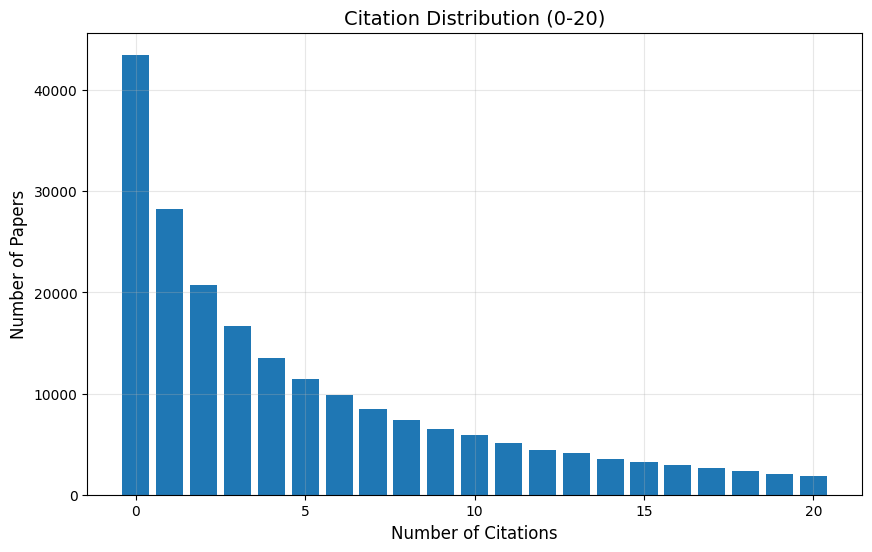


Basic Statistics:
Total papers: 222769
Papers with citations: 179270
Papers with zero citations: 43499
Average citations: 7.14
Median citations: 4.00
Maximum citations: 619


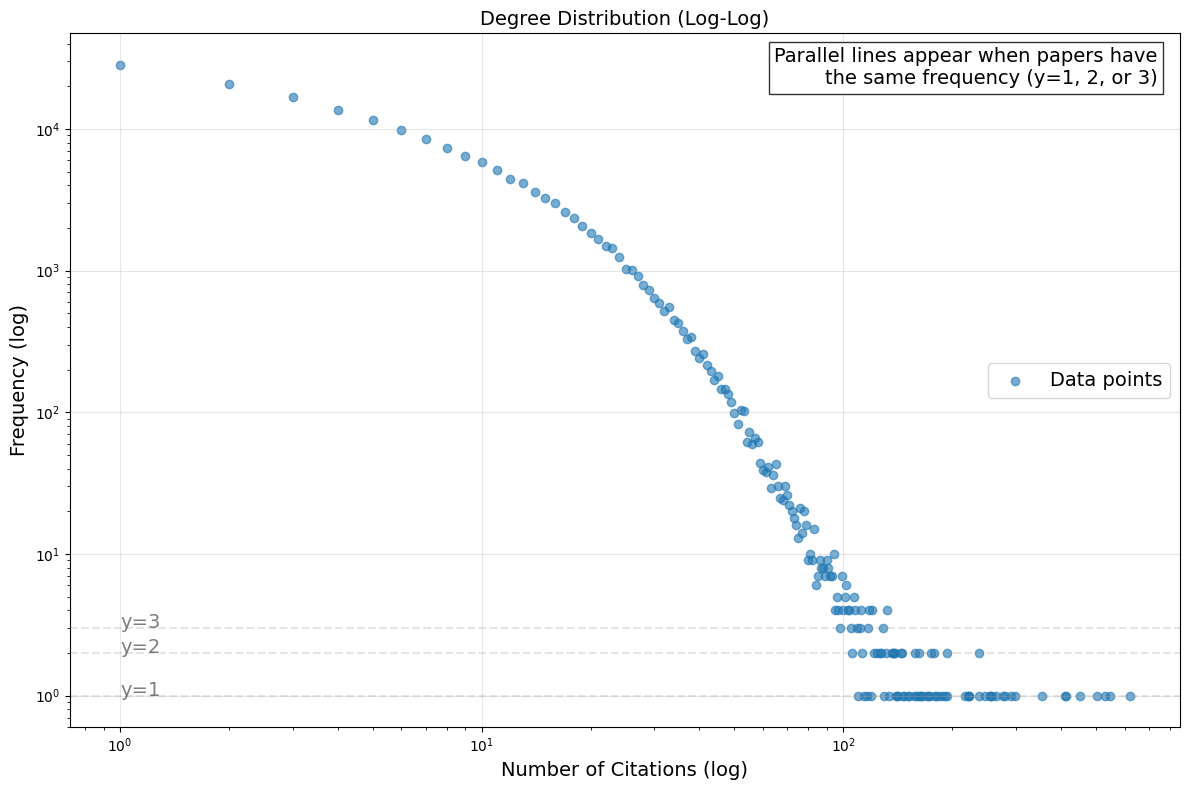

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Calculate out-degrees for all nodes (including isolated nodes)
all_nodes = set(range(len(doi_to_idx)))
out_degrees = edges_df['source'].value_counts()
all_out_degrees = pd.Series(0, index=list(all_nodes))
all_out_degrees[out_degrees.index] = out_degrees

# Create citation distribution table
citation_ranges = list(range(21)) + ['>20']
citation_stats = []

for i in range(21):
    count = len(all_out_degrees[all_out_degrees == i])
    percentage = count / len(all_out_degrees) * 100
    citation_stats.append({
        'Citations': i,
        'Paper Count': count,
        'Percentage': f'{percentage:.2f}%'
    })

# Add statistics for citations > 20
count_above_20 = len(all_out_degrees[all_out_degrees > 20])
percentage_above_20 = count_above_20 / len(all_out_degrees) * 100
citation_stats.append({
    'Citations': '>20',
    'Paper Count': count_above_20,
    'Percentage': f'{percentage_above_20:.2f}%'
})

# Convert to DataFrame and print
stats_df = pd.DataFrame(citation_stats)
print("Citation Distribution Statistics:")
print(stats_df.to_string(index=False))

# Plot improved visualizations as two separate figures

# 1. Bar plot: showing distribution for citations 0-20
plt.figure(figsize=(10, 6))
x = range(21)
y = [len(all_out_degrees[all_out_degrees == i]) for i in x]
plt.bar(x, y)
plt.title('Citation Distribution (0-20)', fontsize=14)  # Increase font size
plt.xlabel('Number of Citations', fontsize=12)  # Increase font size
plt.ylabel('Number of Papers', fontsize=12)  # Increase font size
plt.grid(True, alpha=0.3)
plt.show()

# # 2. Log-log plot of degree distribution
import matplotlib.pyplot as plt
import numpy as np

# Calculate degree distribution
values = all_out_degrees[all_out_degrees > 0].value_counts().sort_index()

# Create improved visualization
plt.figure(figsize=(12, 8))
plt.scatter(values.index, values.values, alpha=0.6, label='Data points')

# Add horizontal lines to show y=1, y=2, y=3 levels
for y in [1, 2, 3]:
    plt.axhline(y=y, color='gray', linestyle='--', alpha=0.2)
    plt.text(1, y, f'y={y}', alpha=0.5, fontsize=14)  # Increase font size

plt.xscale('log')
plt.yscale('log')
plt.title('Degree Distribution (Log-Log)', fontsize=14)  # Increase font size
plt.xlabel('Number of Citations (log)', fontsize=14)  # Increase font size
plt.ylabel('Frequency (log)', fontsize=14)  # Increase font size
plt.grid(True, alpha=0.3)
plt.legend(fontsize=14)  # Increase font size

# Add annotation to explain the parallel points
plt.text(0.98, 0.98, 
         'Parallel lines appear when papers have\nthe same frequency (y=1, 2, or 3)', 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8),
         verticalalignment='top',
         horizontalalignment='right',
         fontsize=14)  # Increase font size

plt.tight_layout()

# plt.figure(figsize=(10, 6))
# values = all_out_degrees[all_out_degrees > 0].value_counts().sort_index()
# plt.scatter(values.index, values.values, alpha=0.6)
# plt.xscale('log')
# plt.yscale('log')
# plt.title('Degree Distribution (Log-Log)')
# plt.xlabel('Number of Citations (log)')
# plt.ylabel('Frequency (log)')
# plt.grid(True, alpha=0.3)
# plt.show()

# Print basic statistics
print("\nBasic Statistics:")
print(f"Total papers: {len(all_out_degrees)}")
print(f"Papers with citations: {len(all_out_degrees[all_out_degrees > 0])}")
print(f"Papers with zero citations: {len(all_out_degrees[all_out_degrees == 0])}")
print(f"Average citations: {all_out_degrees.mean():.2f}")
print(f"Median citations: {all_out_degrees.median():.2f}")
print(f"Maximum citations: {all_out_degrees.max()}")